<br>

## SHapley Additive exPlanations (SHAP) 

SHAP is a game theoretic approach to explain the output of any machine learning model and the features significance.
*[Go to top](#toc)* 

In [34]:
# !pip install catboost
# !pip install ipywidgets

# !pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension

#### Libraries

In [35]:
!jupyter nbextension enable --py widgetsnbextension

from IPython.core.display import display, HTML
from IPython.display import display_html

display(  HTML( '<style>.container { width:49% !important; }</style>' )  )

import os, random, time, fsspec, gunzip, datetime, requests, copy, inspect, collections, itertools

import pandas as pd, pandas_datareader as pd_dr, re
import numpy as np, seaborn as sns
from numpy import savetxt, genfromtxt
import sklearn, sklearn_pandas
from sklearn import *
import missingno as msno
import h5py, pickle, urllib

import scipy, scipy.stats as stats, random, math
from sklearn.pipeline import Pipeline

import matplotlib, graphviz
import matplotlib.pyplot as plt
from matplotlib import *
plt.style.use('classic')

import xgboost
import catboost, pandas_profiling

%matplotlib inline
%config Completer.use_jedi = False

np.random.seed(1) # set a seed so that the results are consistent

## Set Jupyter notebook display options for pandas
pd.set_option( 'display.max_columns', None )
pd.options.display.max_rows = 8

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [5]:
# !pip install shap
import shap

#### SHAP plots

In [27]:
# health_df = pd.read_csv( location + 'healthcare-dataset-stroke-data.csv' )
health_df = pd.read_csv( 'healthcare-dataset-stroke-data.csv' )

health_df.drop( columns= 'id', inplace= True )
health_df = health_df.dropna()

health_df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [30]:
## One hot encoding udf

def OHE_func( df, categorical_col ):
    '''
    function that returns one=hot-encoded dataframe for the given categorical column list.
    Also removes the original column
    input:
    df = dataframe
    categorical_col = list of string of categorical columns to be one-hot encoded '''
    OHEncoder = sklearn.preprocessing.OneHotEncoder( sparse= False, drop= 'first', dtype= np.int8 )
    OHEncoded_np = OHEncoder.fit_transform( df[categorical_col] )
    OHEncoded_df = pd.DataFrame(OHEncoded_np, index= df.index,
                                columns= OHEncoder.get_feature_names(input_features=categorical_col))
    return(  df.drop( columns= categorical_col )\
            .merge( OHEncoded_df, left_index= True, right_index= True )  )    

In [31]:
cat_col = [ 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' ]

healthCat_df = OHE_func( df = health_df, categorical_col= cat_col ) 

# train test
xtrn,xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
                                healthCat_df.drop( columns= 'stroke' ), healthCat_df['stroke'],
                                test_size= 30./100  )
print( ytrn[:2] );  xtrn.head(2)

3219    0
4433    0
Name: stroke, dtype: int64


Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3219,73.0,0,0,65.93,30.3,0,0,1,0,0,0,0,0,0,1,0
4433,21.0,0,0,58.66,31.3,0,0,0,0,1,0,0,1,0,1,0


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:48:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


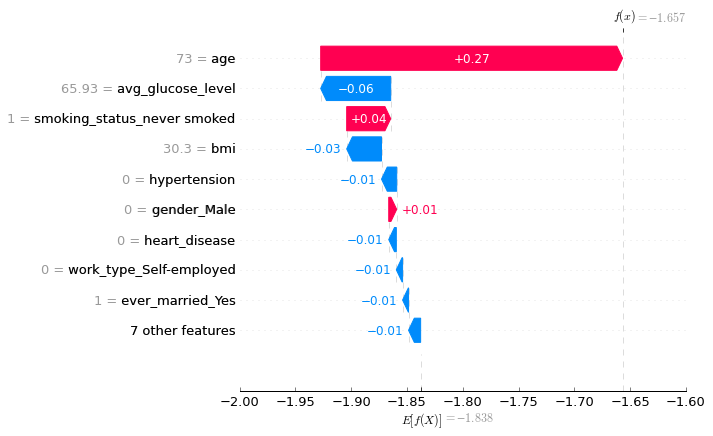

In [32]:
## Water fall plot using xgboost classifier

# boston_df, housePrice = shap.datasets.boston()
xgbReg_est = xgboost.XGBRFClassifier().fit( xtrn, ytrn )

# explain the model's predictions using SHAP
shapExplainer = shap.Explainer( model= xgbReg_est )
shapVal_np = shapExplainer( X= xtrn )

# visualize the first prediction's explanation
shap.plots.waterfall( shap_values= shapVal_np[0] )

#### Beeswarm plot

To get an overview of which features are most important for a model we plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

The color represents the feature value (red high, blue low). This reveals for example that a high `Age` increases the chance of stroke, while `Married status` decreases the chance of Stroke.

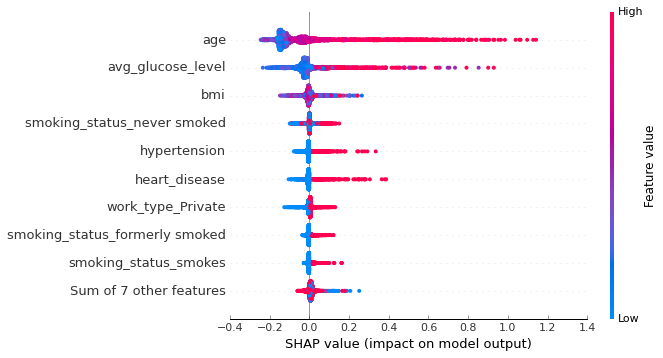

In [12]:
shap.plots.beeswarm( shap_values= shapVal_np )

Plotting the mean absolute value of the SHAP values for each feature as a bar plot (it produces stacked bars for multi-class outputs)

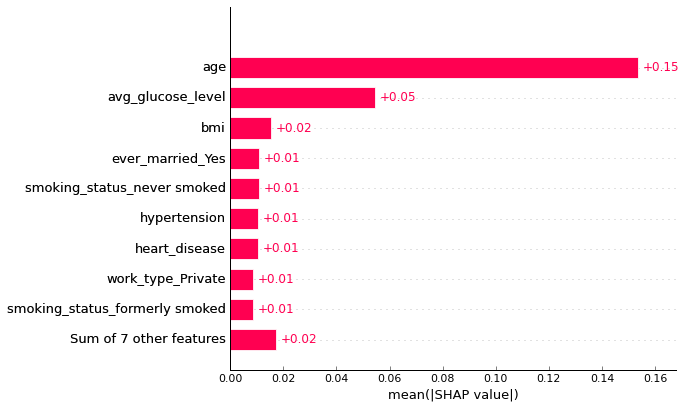

In [13]:
shap.plots.bar( shap_values= shapVal_np )

#### other SHAP plots

In [17]:
## Random forest

randForest_est = sklearn.ensemble.RandomForestClassifier(  )
randForest_est.fit( xtrn, ytrn )

yhat = randForest_est.predict( xtst )

f1_score, accuracy_RF = sklearn.metrics.f1_score( ytst, yhat, average= 'macro' ), sklearn.metrics.accuracy_score( ytst, yhat )

print(  'F1 score --> {:0.3f} \t | \t  Accuracy --> {:0.3f}'.format(f1_score,accuracy_RF)  )

F1 score --> 0.501 	 | 	  Accuracy --> 0.951


#### `SHAP` internal variables

In [18]:
# create shap explainer
shapExplainer = shap.TreeExplainer( model= randForest_est )

# calc shapley vlaues for test data
start_idx, end_idx = 200,201
shapVal_np = shapExplainer.shap_values( X= xtst[start_idx:end_idx] )

print( len( shapVal_np ), shapVal_np[0].shape, '\n' );                 print( shapVal_np[0], '\n' )

2 (1, 16) 

[[-1.08219123e-01  1.11755995e-02 -3.82751588e-02  1.97845649e-02
  -1.57975382e-02  4.02829839e-03  0.00000000e+00  1.06515830e-03
  -1.19224329e-06  1.06221076e-02  2.27657476e-04 -1.94781812e-03
   1.19625838e-02  4.88206827e-04 -3.25634449e-04  5.89913360e-03]] 



`Force plots` allows to observe how features contributed to the model’s prediction for a specific observation. 

The binary target was person had a Stroke ( = 1), or no they didn’t had ( = 0). In the plot below, the bold 0.02 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.
So this particular person was ultimately classified as will not have Stroke (0), because they were pushed higher by all the factors shown in Blue ( Avg Glucose level, no hypertension, no heart disease, etc. ).

In [19]:
## visualize local prediction

shap.initjs()

yhat = randForest_est.predict( xtst[start_idx:end_idx] )[0]
print( f'Random Forest Prediction --> {yhat}' )

shap.force_plot( base_value= shapExplainer.expected_value[1], shap_values= shapVal_np[1],
                 features= xtst[start_idx:end_idx] )

Random Forest Prediction --> 0


If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (as done below)

In [21]:
## shap plot for all (or many) obvs

idx_upto = 50
# create shap explainer
shapExplainer = shap.TreeExplainer( model= randForest_est )

# calc shapley vlaues for test data
shapVal_np = shapExplainer.shap_values( X= xtst )

## visualize local prediction
shap.plots.force( base_value= shapExplainer.expected_value[1],shap_values= shapVal_np[1][:idx_upto] )

In [23]:
## shap plot for some (zooming in)
idx_upto = 7
shap.plots.force( base_value= shapExplainer.expected_value[1],shap_values= shapVal_np[1][:idx_upto] )

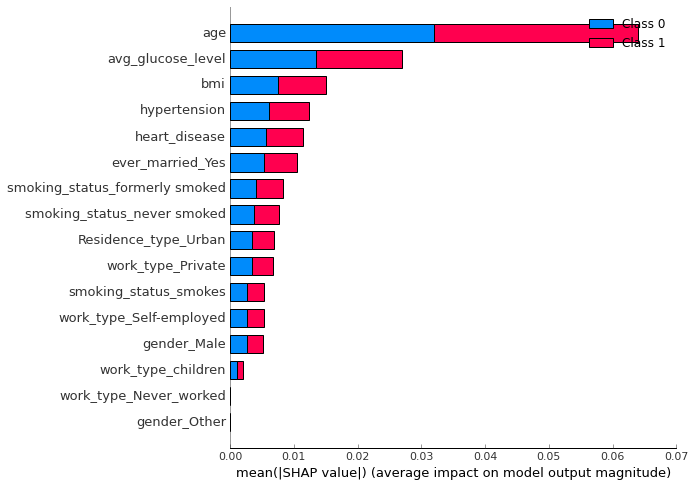

In [24]:
shap.summary_plot( shap_values= shapVal_np, features= xtst )

### SHAP Dependence Plots

A SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions.

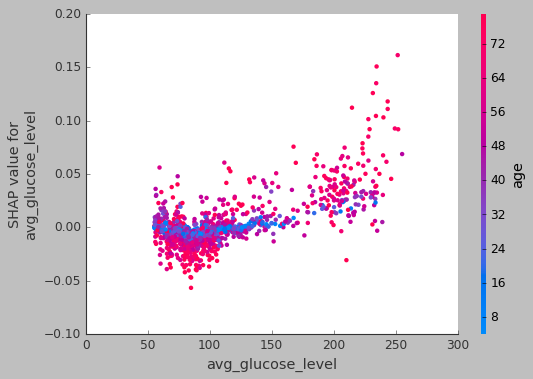

In [66]:
shap.dependence_plot( ind= 'avg_glucose_level', shap_values= shapVal_np[1],  # <-- index 1 is the stroke = yes case
                      features= xtst, show= False )

### SHAP Dependence Plots with Interaction effect

Plotting the `interaction effects` involving `age`. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

In [74]:
shap_interaction_values = shap.TreeExplainer( model= randForest_est ).shap_interaction_values( X= xtst )

In [86]:
xtst.head(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2648,52.0,0,0,87.26,40.1,1,0,1,0,0,0,0,0,0,0,1
3441,59.0,0,0,90.06,28.9,0,0,1,0,0,1,0,1,0,0,1


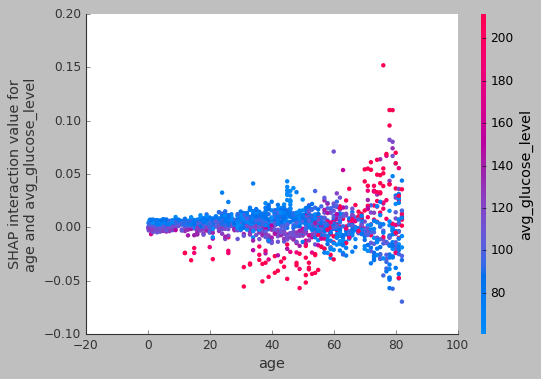

In [104]:
shap.dependence_plot(  ind= ( 'age', 'avg_glucose_level' ), shap_values= shap_interaction_values[1], features= xtst )

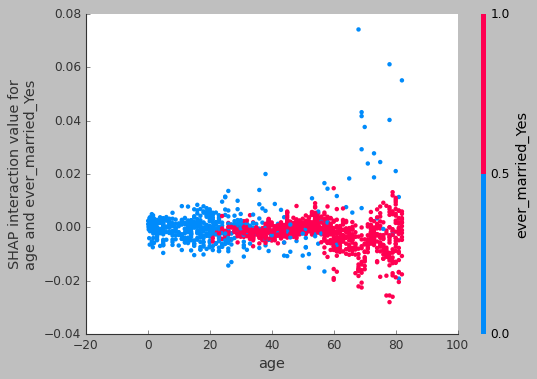

In [106]:
shap.dependence_plot(  ind= ( 'age', 'ever_married_Yes' ), shap_values= shap_interaction_values[1], features= xtst )